# Synthetic 1D inversion of Audio Magnetotelluric data


## 0. Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cofi
from espresso import Magnetotelluric1D
from espresso._magnetotelluric_1D import get_frequencies, forward_1D_MT, z2rhophy, add_noise

In [2]:
mt = Magnetotelluric1D()

### Create synthetic data given a 5 layers Earth model

#### 0.1. Define a resistivity model and plot it

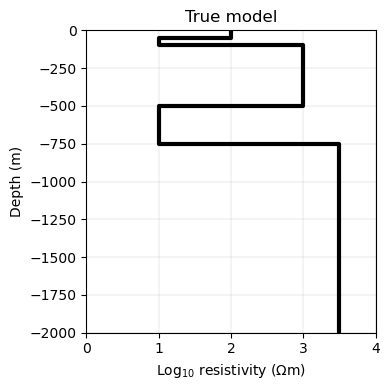

In [3]:
# layer electrical resitivity in log10 ohm.m 
true_model = np.array([2,1,3,1,3.5]) 
# depths in meters to the bottom of each layer (positive downwards), last layer infinite: len(true_depths)+1 = len(true_model)
true_depths = np.array([50,100,500,750])
# plot the model
max_depth = -2000
fig = mt.plot_model(true_model, true_depths, max_depth = max_depth, title='True model')

#### 0.2. Compute response of the model

Compute synthetic data, add noise, define the data / errors and plot

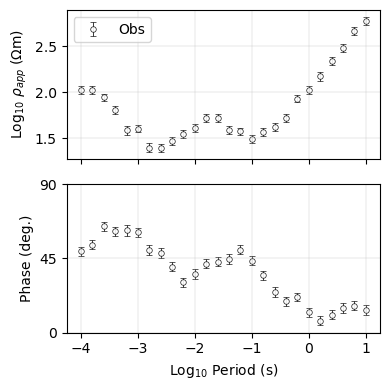

In [4]:
# define frequencies (in Hz) where responses are computed
fmin, fmax, f_per_decade = 1e-1, 1e4, 5
freqs = get_frequencies(fmin,fmax,f_per_decade)
# generate synthetic data 
# calculate impedance Z
Z = forward_1D_MT(true_model, true_depths, freqs, return_Z = True)
# add noise
Z, Zerr = add_noise(Z, percentage = 5, seed = 1234)
# transform Z to log10 apparent resistivity and phase (dobs)
dobs, derr = z2rhophy(freqs, Z, dZ=Zerr)
#set observed data
mt.set_obs_data(dobs, derr, freqs)
# plot the data
fig = mt.plot_data(mt.data, Cm = mt.covariance_matrix)

#### 0.3. Define a starting 1D mesh and model for the inversion

In [5]:
# the mesh used for the inversion contains many cells to produce a smooth model
nLayers, min_thickness, vertical_growth= 80, 5, 1.1
thicknesses = [min_thickness * vertical_growth**i for i in range(nLayers)]
starting_depths = np.cumsum(thicknesses)
starting_model = np.ones((len(starting_depths)+1)) * 2 # 100 ohm.m starting model (log10 scale) 
print('Model bottom: %.2f m'%starting_depths[-1])

Model bottom: 102370.01 m


#### 0.4. Set new starting model and mesh

In [6]:
mt.set_start_model(starting_model)
mt.set_start_mesh(starting_depths)

## 1. Define the problem

In [7]:
# define CoFI BaseProblem
mt_problem = cofi.BaseProblem()
mt_problem.set_initial_model(mt.starting_model)

In [8]:
# add regularization: smoothing
smoothing_factor = 50
reg_smoothing = cofi.utils.QuadraticReg(smoothing_factor, model_size = mt.model_size, reg_type = "smoothing")
reg = reg_smoothing

In [9]:
def objective_func(model, reg):
    dpred = mt.forward(model)
    data_misfit = mt.misfit(mt.data,dpred,mt.inverse_covariance_matrix)
    model_reg = reg(model)
    return  data_misfit + model_reg

In [10]:
mt_problem.set_objective(objective_func, args=[reg])

In [11]:
#mt_problem.summary()

## 2. Define the inversion options

In [12]:
#mt_problem.suggest_tools();

In [13]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="L-BFGS-B",options={'ftol':1e-3,'maxiter': 100})
#my_options.summary()

In [14]:
#my_options.suggest_solver_params()

## 3. Start an inversion

In [15]:
print("Running inversion...")
inv = cofi.Inversion(mt_problem, my_options)
inv_result = inv.run()
print("   done!")

Running inversion...
   done!


In [16]:
inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
fun: 65.79911041272914
jac: [ 1.52895155  1.22772833 -0.88282378 -0.51289391  0.65275856  0.79565723
 -0.89612229 -1.71288833 -0.96344195  0.02720384  0.72738118  1.1050986
  0.76454825  0.06305214 -0.07781296 -0.02576144 -0.37865249 -0.26876705
  0.15340191 -0.06512266  0.04327205  0.5780322  -0.17707578 -1.00214664
  0.13782966  0.66997501 -1.0848126  -1.35927821  0.58472836  0.63415087
 -0.65878112  0.00503348  0.94475326 -0.04268941 -0.75952329 -0.08236185
 -0.21712907 -1.16404096 -0.56451484  1.12873693  1.33657068 -0.25000731
 -1.46546314 -0.64126909  1.18801751  1.35220547 -0.41967781 -1.38103645
 -0.49980713  0.31220537  0.33432173  0.40226098  0.21690738 -0.19741009
  0.27767442  0.7966122   0.16443096  0.17232793  1.27315617  0.69559292
 -1.015664   -0.61836261  0.80842853  0.72265181  0.15060238 -0.16639774
 -0.9006115  -0.88622301 -0.06632632 -0.45892534 -0.93212265  0.10145982
  0.43035584 -1.06583827 -1.452

## 4. Plotting inversion results

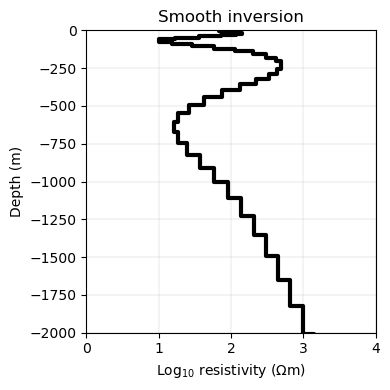

In [17]:
fig1 = mt.plot_model(inv_result.model, max_depth = max_depth, title='Smooth inversion');            # inverted model

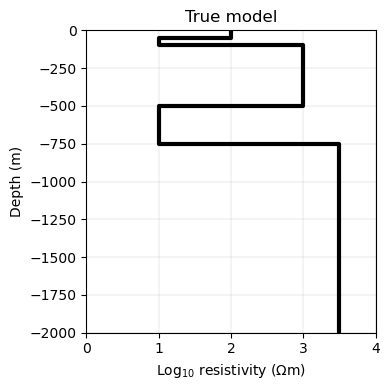

In [18]:
fig2 = mt.plot_model(true_model, true_depths, max_depth = max_depth, title='True model');       # true model

nRMSE = 1.003


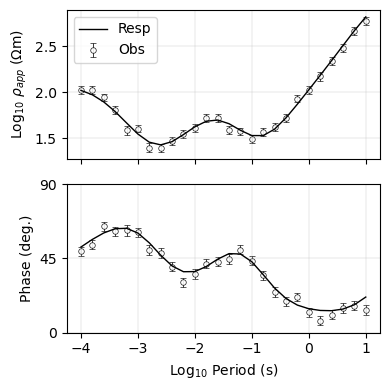

In [19]:
fig = mt.plot_data(mt.data, mt.forward(inv_result.model), Cm = mt.covariance_matrix)
nRMSE = np.sqrt(mt.misfit(mt.data, mt.forward(inv_result.model), Cm_inv = mt.inverse_covariance_matrix)/mt.data_size)
print('nRMSE = %.3f'%nRMSE)